In [17]:
import numpy as np
import pandas as pd
import openap
from openap import top
import matplotlib.pyplot as plt

## define the aircraft type, origin and destination airports

In [21]:
typecode = "A320"
origin = "EHAM"
destination = "LGAV"

# initial mass as the faction of maximum takeoff mass
m0 = 0.85

## simple fuel optimal trajectory

In [ ]:
optimizer = top.CompleteFlight(typecode, origin, destination, m0=m0)

flight = optimizer.trajectory(objective="fuel")

flight.head()

,ts,x,y,h,latitude,longitude,altitude,mach,tas,vertical_rate,heading,fuel,mass
0,0.0,-652425.011696,840651.921623,30.480000,52.316584,4.746242,100.0,0.3000,198.38,2414.0,129.51,423.01,66300.0
1,238.0,-634114.498195,825554.860619,2951.650726,52.202120,5.040443,9684.0,0.5000,319.54,1965.0,136.98,347.96,65877.0
2,476.0,-607833.123973,797389.593761,5329.504566,51.978660,5.471298,17485.0,0.6176,383.19,1465.0,136.98,299.12,65529.0
3,715.0,-576181.944377,763469.604918,7102.217524,51.707503,5.984523,23301.0,0.6936,420.44,1170.0,136.98,268.30,65230.0
4,953.0,-541376.292916,726169.026417,8518.040283,51.406799,6.541851,27946.0,0.7622,453.16,918.0,136.98,243.85,64962.0


<module 'matplotlib.pyplot' from '/home/junzi/env/flight/lib/python3.12/site-packages/matplotlib/pyplot.py'>

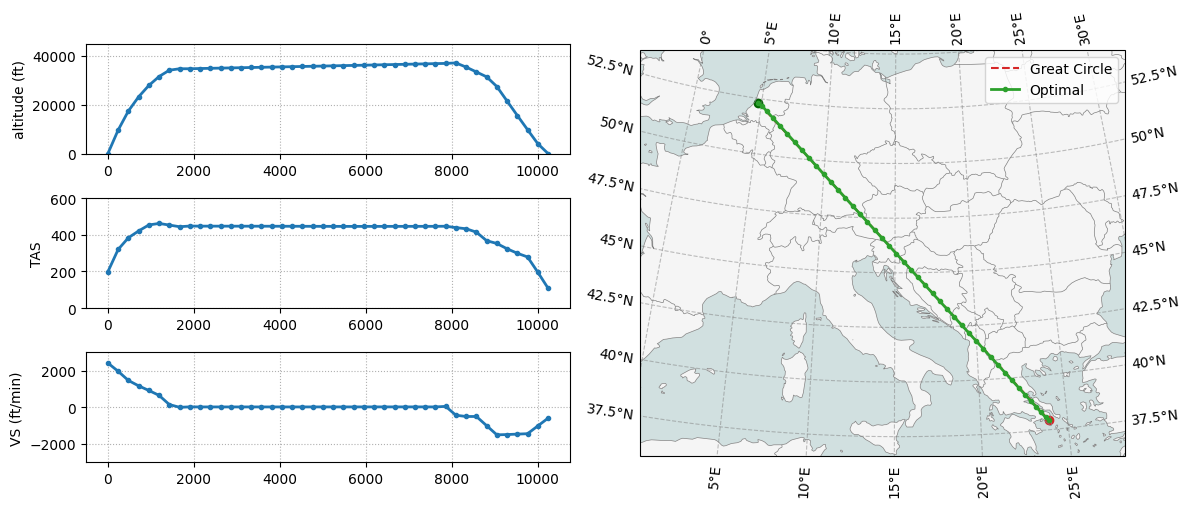

In [4]:
top.vis.trajectory(flight, windfield=None, barb_steps=15)
# plt.show()

## enable the wind

In [10]:
from fastmeteo.source import ArcoEra5

# get the boundary of the wind field
o = openap.nav.airport(origin)
d = openap.nav.airport(destination)

latmin = round(min(o["lat"], d["lat"])) - 2
latmax = round(max(o["lat"], d["lat"])) + 2
lonmin = round(min(o["lon"], d["lon"])) - 4
lonmax = round(max(o["lon"], d["lon"])) + 4

# create the and flatten the wind grid
latitudes = np.arange(latmin, latmax, 0.5)
longitudes = np.arange(lonmin, lonmax, 1)
altitudes = np.arange(1000, 46000, 2000)
timestamps = pd.date_range("2022-02-20 08:00:00", "2022-02-20 11:00:00", freq="1H")

latitudes, longitudes, altitudes, times = np.meshgrid(
    latitudes, longitudes, altitudes, timestamps
)

grid = pd.DataFrame().assign(
    latitude=latitudes.flatten(),
    longitude=longitudes.flatten(),
    altitude=altitudes.flatten(),
    timestamp=times.flatten(),
)

# obtain the wind based on the grid
era5_grid = ArcoEra5(local_store="/tmp/era5-zarr")

meteo_data = era5_grid.interpolate(grid)

init local zarr from remote, hour: 2022-02-20 08:00:00
syncing from remote, hour: 2022-02-20 09:00:00
syncing from remote, hour: 2022-02-20 10:00:00
syncing from remote, hour: 2022-02-20 11:00:00


In [11]:
meteo_data.head()

,latitude,longitude,altitude,timestamp,u_component_of_wind,v_component_of_wind,temperature,specific_humidity
0,36.0,1.0,1000.0,2022-02-20 08:00:00,-0.253531,-0.16565,284.398458,0.007798
1,36.0,1.0,1000.0,2022-02-20 09:00:00,-0.253531,-0.16565,284.398458,0.007798
2,36.0,1.0,1000.0,2022-02-20 10:00:00,-0.253531,-0.16565,284.398458,0.007798
3,36.0,1.0,1000.0,2022-02-20 11:00:00,-0.253531,-0.16565,284.398458,0.007798
4,36.0,1.0,3000.0,2022-02-20 08:00:00,-0.551388,-1.29355,280.141433,0.006976


In [12]:
wind = (
    meteo_data.rename(
        columns={
            "u_component_of_wind": "u",
            "v_component_of_wind": "v",
        }
    )
    .assign(ts=lambda x: (x.timestamp - x.timestamp.iloc[0]).dt.total_seconds())
    .eval("h=altitude * 0.3048")
)[["ts", "latitude", "longitude", "h", "u", "v"]]

wind.head()

,ts,latitude,longitude,h,u,v
0,0.0,36.0,1.0,304.8,-0.253531,-0.16565
1,3600.0,36.0,1.0,304.8,-0.253531,-0.16565
2,7200.0,36.0,1.0,304.8,-0.253531,-0.16565
3,10800.0,36.0,1.0,304.8,-0.253531,-0.16565
4,0.0,36.0,1.0,914.4,-0.551388,-1.29355


In [ ]:
optimizer = top.CompleteFlight(typecode, origin, destination, m0)
optimizer.enable_wind(wind)
flight = optimizer.trajectory(objective="fuel")

<module 'matplotlib.pyplot' from '/home/junzi/env/flight/lib/python3.12/site-packages/matplotlib/pyplot.py'>

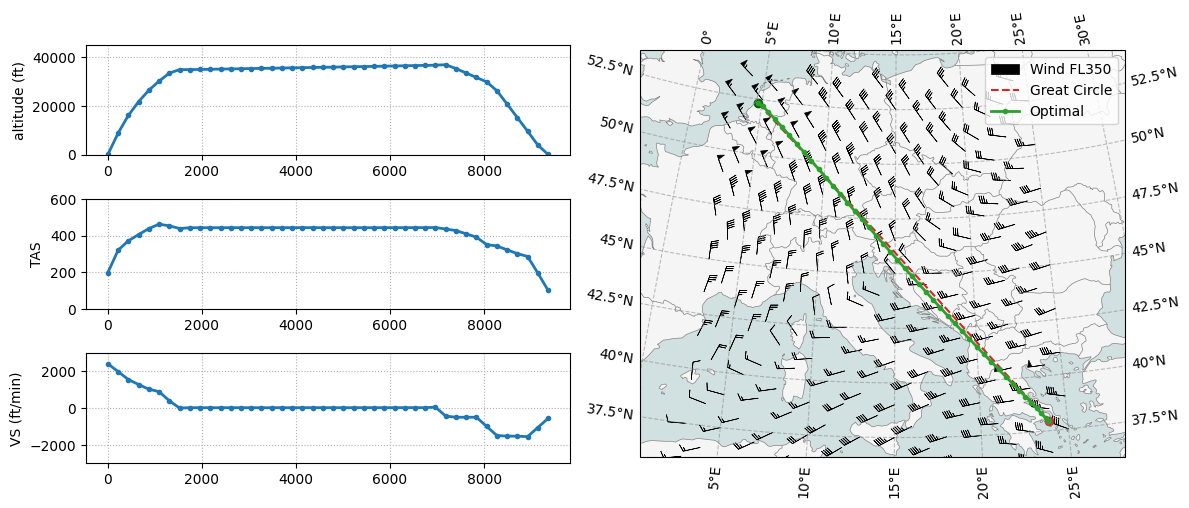

In [15]:
top.vis.trajectory(flight, windfield=wind, barb_steps=15)

## Using a imaginary cost grid over Europe

In [16]:
def gaussian(x, y, z, t):
    return (
        np.exp(-((x + 3 - i) ** 2 + (y - 1) ** 2))
        + np.exp(-((x - 3 + i / 2) ** 2 + (y + 2) ** 2))
    ) * z**2


x = np.linspace(-8, 8, 40)
y = np.linspace(-4, 4, 40)
z = np.linspace(1, 2, 32)
X, Y, Z = np.meshgrid(x, y, z)

# add the time dimension
ts = np.arange(0, 8 * 1800, 1800)  # every 30 minutes
costs4d = np.zeros((len(x), len(y), len(z), len(ts)))

for i, ts_ in enumerate(ts):
    costs3d = gaussian(X, Y, Z, ts)
    costs4d[:, :, :, i] = costs3d

costs4d = (costs4d - costs4d.min()) / (costs4d.max() - costs4d.min())

# scale the x,y to lon,lat bound
lon = np.interp(x, (min(x), max(x)), (-10, 40))
lat = np.interp(y, (min(y), max(y)), (35, 60))
alt = np.interp(z, (min(z), max(z)), (0, 40_000))

lons, lats, alts, tss = np.meshgrid(lon, lat, alt, ts)

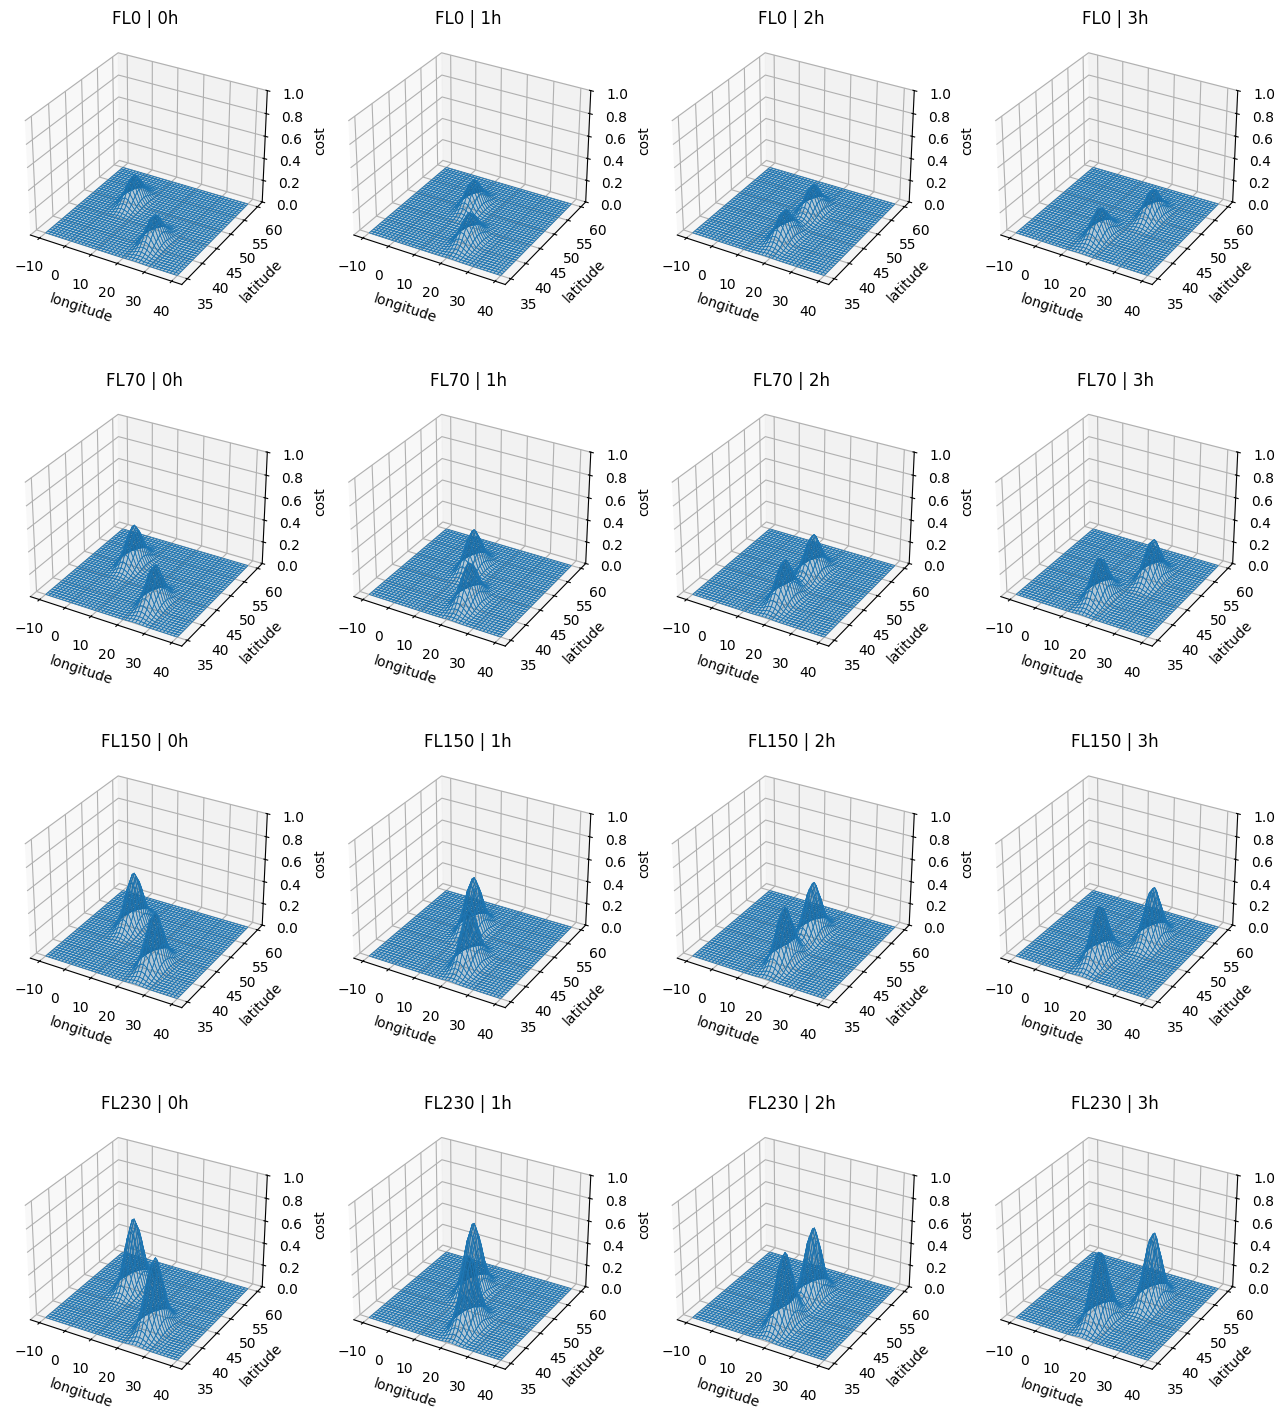

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(16, 18), subplot_kw={"projection": "3d"})
for i, ax in enumerate(axes.flatten()):
    ax.plot_surface(
        lons[:, :, i // 4 * 6, i % 4 * 2],
        lats[:, :, i // 4 * 6, i % 4 * 2],
        costs4d[:, :, i // 4 * 6, i % 4 * 2],
        edgecolor="tab:blue",
        lw=0.5,
        alpha=0.3,
    )
    ax.set_zlim(0, 1)
    flight_level = int(alt[i // 4 * 6] // 1000 * 10)
    time = ts[i % 4 * 2] / 1800 / 2
    ax.set_title(f"FL{flight_level} | {int(time)}h")
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    ax.set_zlabel("cost", rotation=90)

plt.show()

In [19]:
df_cost_4d = pd.DataFrame(
    np.array([lons, lats, alts, tss, costs4d]).reshape(5, -1).T,
    columns=["longitude", "latitude", "altitude", "ts", "cost"],
).assign(height=lambda x: x.altitude * 0.3048)

df_cost_4d

,longitude,latitude,altitude,ts,cost,height
0,-10.0,35.0,0.0,0.0,4.836940e-23,0.0
1,-10.0,35.0,0.0,1800.0,8.078512e-28,0.0
2,-10.0,35.0,0.0,3600.0,1.826010e-33,0.0
3,-10.0,35.0,0.0,5400.0,5.615118e-40,0.0
4,-10.0,35.0,0.0,7200.0,3.049747e-38,0.0
...,...,...,...,...,...,...
409595,40.0,60.0,40000.0,5400.0,1.995862e-32,12192.0
409596,40.0,60.0,40000.0,7200.0,6.490450e-26,12192.0
409597,40.0,60.0,40000.0,9000.0,2.871462e-20,12192.0
409598,40.0,60.0,40000.0,10800.0,1.719263e-15,12192.0


In [ ]:
optimizer = top.CompleteFlight(typecode, origin, destination, m0=m0)
# optimizer.setup(debug=True)

interpolant = top.tools.interpolant_from_dataframe(df_cost_4d)


def objective(x, u, dt, **kwargs):
    """The final objective is the compound of grid cost and fuel"""
    grid_cost = optimizer.obj_grid_cost(
        x, u, dt, n_dim=4, time_dependent=True, **kwargs
    )
    fuel_cost = optimizer.obj_fuel(x, u, dt, **kwargs)
    return grid_cost + fuel_cost * 2


# generate the flight trajectory
# interpolant is passed to trajectory(), and internally used by obj_grid()
flight = optimizer.trajectory(objective=objective, interpolant=interpolant)

<module 'matplotlib.pyplot' from '/home/junzi/env/flight/lib/python3.12/site-packages/matplotlib/pyplot.py'>

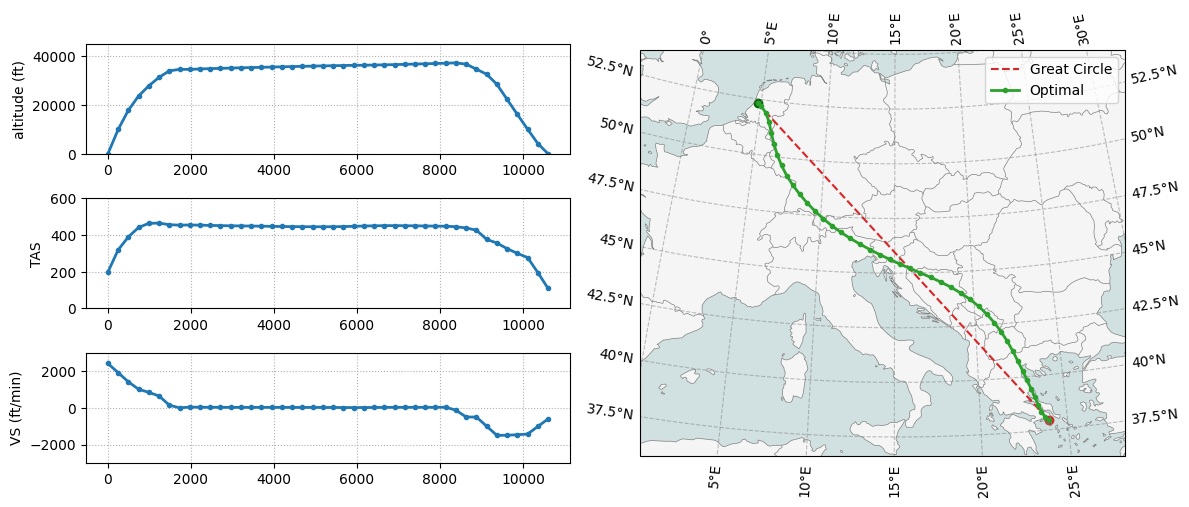

In [22]:
top.vis.trajectory(flight)

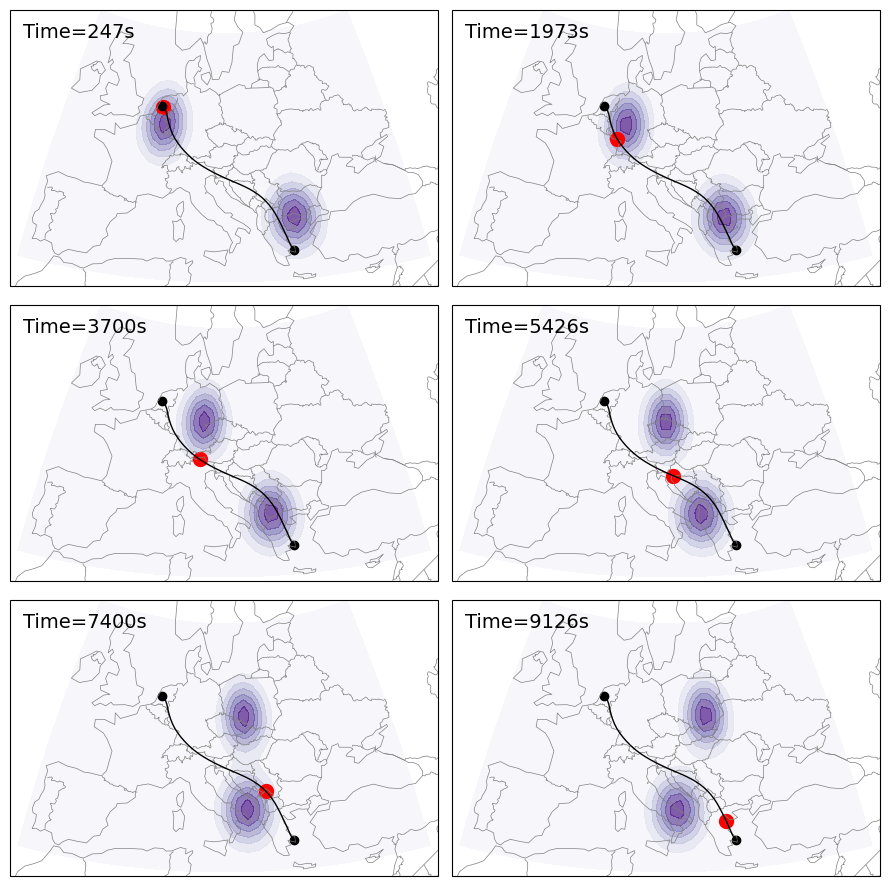

In [23]:
def flight_level_cost_4d(flight, df_cost):
    from cartopy import crs as ccrs
    from cartopy.feature import BORDERS

    proj = ccrs.PlateCarree()

    fig, axes = plt.subplots(
        3,
        2,
        figsize=(9, 9),
        subplot_kw=dict(
            projection=ccrs.TransverseMercator(
                central_longitude=15, central_latitude=45
            )
        ),
    )

    for i, ax in enumerate(axes.flatten()):
        ax.set_extent([-10, 40, 32, 60])
        ax.add_feature(BORDERS, lw=0.5, color="gray")
        ax.coastlines(resolution="110m", lw=0.5, color="gray")

        df_cost_pivot = df_cost.query(
            f"height=={df_cost.height.max()} and ts=={i * 1800}"
        ).pivot(index="latitude", columns="longitude", values="cost")

        lat, lon, val = (
            df_cost_pivot.index.values,
            df_cost_pivot.columns.values,
            df_cost_pivot.values,
        )

        ax.contourf(lon, lat, val, transform=proj, alpha=0.7, cmap="Purples")

        current = flight.query(f"{i * 1800}<ts<{i * 1800 + 600}").iloc[0]

        ax.text(
            0.03, 0.9, f"Time={int(current.ts)}s", transform=ax.transAxes, fontsize=14
        )

        ax.scatter(current.longitude, current.latitude, color="r", lw=5, transform=proj)

        ax.plot(flight.longitude, flight.latitude, color="k", lw=1, transform=proj)

        for r, p in flight.iloc[[0, -1]].iterrows():
            ax.scatter(p.longitude, p.latitude, c="k", transform=proj)

    plt.tight_layout()
    plt.show()


flight_level_cost_4d(flight, df_cost_4d)